```{currentmodule} tskit
```

(sec_tskit_viz)=

In [1]:
import msprime
import io
import tskit

def viz_ts():
    dem = msprime.Demography.from_species_tree("((A:900,B:900)ab:100,C:1000)abc;", initial_size=1e3)
    samples = {"A": 20, "B": 20, "C":20}  # take 20 diploids from terminal populations A, B, C
    ts_full = msprime.sim_ancestry(
        samples, demography=dem, sequence_length=5e4, recombination_rate=1e-8, random_seed=1234
    )
    ts_full.dump("data/viz_ts_full.trees")

    first_4_nodes = [0, 1, 2, 3]  # ids of the first 4 sample nodes (here, 2 individuals from A)
    ts_tiny = ts_full.simplify(first_4_nodes)  # a tiny 4-tip TS
    ts_tiny.dump("data/viz_ts_tiny.trees")

    eight_nodes = first_4_nodes + [40, 41, 80, 81]  # Add nodes from individuals in B & C
    ts_small = ts_full.simplify(eight_nodes)   # a small 8-tip TS
    ts_small.dump("data/viz_ts_small.trees")

    ts_small_mutated = msprime.sim_mutations(ts_small, rate=1e-7, random_seed=342)
    # 3rd tree should have first site with 2 muts
    first_site_tree_2 = next(ts_small_mutated.at_index(2).sites())
    assert len(first_site_tree_2.mutations) == 2
    # mutation 8 should be above node 16 in the 1st tree
    assert ts_small_mutated.site(8).mutations[0].id == 8
    assert ts_small_mutated.site(8).mutations[0].node == 16
    ts_small_mutated.dump("data/viz_ts_small_mutated.trees")

def viz_selection():
    sequence_length = 5e4
    sweep_model = msprime.SweepGenicSelection(position=sequence_length/2,
    s=0.01, start_frequency=0.5e-4, end_frequency=0.99, dt=1e-6)
    ts_selection = msprime.sim_ancestry(9,
        model=[sweep_model, msprime.StandardCoalescent()],
        population_size=1e4,
        recombination_rate=1e-8,
        sequence_length=sequence_length,
        random_seed=9,
    )
    ts_selection.dump("data/viz_ts_selection.trees")

def viz_root_mut():
    """
    Taken from the drawing unit tests
    """
    nodes = io.StringIO(
        """\
    id      is_sample   population      individual      time    metadata
    0       1       0       -1      0
    1       1       0       -1      0
    2       1       0       -1      0
    3       1       0       -1      0
    4       0       0       -1      0.1145014598813
    5       0       0       -1      1.11067965364865
    6       0       0       -1      1.75005250750382
    7       0       0       -1      5.31067154311640
    8       0       0       -1      6.57331354884652
    9       0       0       -1      9.08308317451295
    """
    )
    edges = io.StringIO(
        """\
    id      left   right   parent  child
    0       0      100     4       0
    1       0      100     4       1
    2       0      100     5       2
    3       0      100     5       3
    4       80     85      6       4
    5       80     85      6       5
    6       6      80      7       4
    7       85     91      7       4
    8       6      80      7       5
    9       85     91      7       5
    10      91     100     8       4
    11      91     100     8       5
    12      0      6       9       4
    13      0      6       9       5
    """
    )
    sites = io.StringIO(
        """\
    position    ancestral_state
    4           A
    6           0
    30          Empty
    50          XXX
    91          T
    """
    )
    muts = io.StringIO(
        """\
    site   node    derived_state    parent    time
    0      9       T                -1        15
    0      9       G                0         9.1
    0      5       1                1         9
    1      4       C                -1        1.6
    1      4       G                3         1.5
    2      7       G                -1        10
    2      3       C                5         1
    4      3       G                -1        1
    """
    )
    ts = tskit.load_text(nodes, edges, sites=sites, mutations=muts, strict=False)
    ts.dump("data/viz_root_mut.trees")

def viz_spr_animation():
    # created with record_full_arg needed to track recombination nodes (branch positions)
    # random_seed chosen to produce a ts whose leaves are plotted in the same order
    ts = msprime.sim_ancestry(
        5, ploidy=1,
        sequence_length=10000,
        recombination_rate=0.00005,
        random_seed=6787, model="smc_prime", record_full_arg=True)                
    ts.dump("data/viz_spr_animation.trees")

def create_notebook_data():
    viz_ts()
    viz_selection()
    viz_root_mut()
    viz_spr_animation()

# create_notebook_data()  # uncomment to recreate the tree seqs used in this notebook

# Visualization

**Yan Wong**

It is often helpful to visualize a single tree --- or multiple trees along a tree
sequence --- together with sites and mutations. {ref}`Tskit <tskit:sec_introduction>`
provides functions to do this, outputting either plain ascii or unicode text, or the more
flexible [Scalable Vector Graphics](https://www.w3.org/TR/SVG11/) (SVG) format.
This tutorial illustrates various examples, based on a few 50kb tree sequences generated by
{ref}`msprime <msprime:sec_intro>`, in which genomes have been sampled from one of 3
contemporary populations (labelled _A_, _B_, and _C_).

In [2]:
import tskit
# See the notebook code if you want to know how these tree sequences were produced
ts_tiny = tskit.load("data/viz_ts_tiny.trees")
ts_small = tskit.load("data/viz_ts_small.trees")
ts_full = tskit.load("data/viz_ts_full.trees")

If you just want a quick look at visualization possibilities, you might want to skip to
the {ref}`sec_tskit_viz_examples`.

:::{note}
This tutorial is primarily focussed on showing a tree sequence as a set of marginal
trees along a genome. The section titled {ref}`sec_tskit_viz_other`
provides examples of other representations of tree sequences, or the processes that
can create them. 
:::


## Text format

The {meth}`TreeSequence.draw_text` and
{meth}`Tree.draw_text` methods provide
a quick way to print out a tree sequence, or an individual tree within it. They are
primarily useful for looking at topologies in small datasets (e.g. fewer than 20 sampled
genomes), and do not display mutations.

In [3]:
# Print a tree sequence
print(ts_tiny.draw_text())

print("The first tree in the tree sequence above, but replacing some node ids with names:")
print(ts_tiny.first().draw_text(
    # An example of how to change or omit node labels: unspecified nodes are omitted
    # The same convention applies to SVG graphics
    node_labels={0: "Alice", 1: "Bob", 2:"Chris", 3: "Dora", 6: "MRCA"}
))

11428.48┊         ┊         ┊         ┊         ┊   13    ┊         ┊         ┊         ┊  
        ┊         ┊         ┊         ┊         ┊  ┏━┻━┓  ┊         ┊         ┊         ┊  
11144.74┊         ┊         ┊         ┊         ┊  ┃   ┃  ┊   12    ┊         ┊         ┊  
        ┊         ┊         ┊         ┊         ┊  ┃   ┃  ┊  ┏━┻━┓  ┊         ┊         ┊  
9753.69 ┊         ┊         ┊         ┊         ┊  ┃   ┃  ┊  ┃   ┃  ┊   11    ┊         ┊  
        ┊         ┊         ┊         ┊         ┊  ┃   ┃  ┊  ┃   ┃  ┊  ┏━┻━┓  ┊         ┊  
6204.42 ┊         ┊         ┊         ┊   10    ┊  ┃   ┃  ┊  ┃   ┃  ┊  ┃   ┃  ┊         ┊  
        ┊         ┊         ┊         ┊  ┏━┻━┓  ┊  ┃   ┃  ┊  ┃   ┃  ┊  ┃   ┃  ┊         ┊  
3893.05 ┊         ┊         ┊         ┊  ┃   ┃  ┊  ┃   ┃  ┊  ┃   ┃  ┊  ┃   ┃  ┊    9    ┊  
        ┊         ┊         ┊         ┊  ┃   ┃  ┊  ┃   ┃  ┊  ┃   ┃  ┊  ┃   ┃  ┊  ┏━┻━┓  ┊  
3378.92 ┊         ┊    8    ┊    8    ┊  ┃   ┃  ┊  ┃   ┃  ┊  ┃   ┃  ┊  ┃   ┃  ┊ 

## SVG format

Most users will want to use the SVG drawing functions
{meth}`TreeSequence.draw_svg` and
{meth}`Tree.draw_svg` for visualization. Being a vectorised
format, SVG files are suitable for presentations, publication, and
{ref}`editing or converting <sec_tskit_viz_converting>` to other graphic formats; some
basic forms of animation are also possible. Both functions produce an SVG string which is
automatically drawn if the string is the result of the last call in a Jupyter notebook:

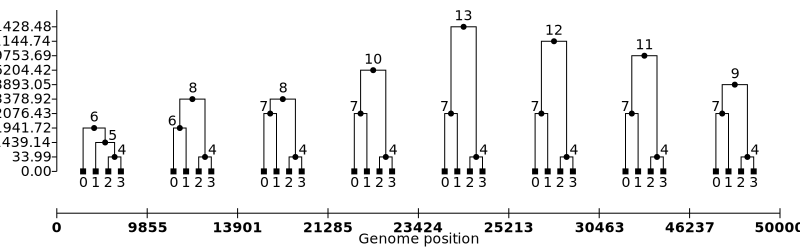

In [4]:
from IPython.display import display
svg_size = (800, 250) # Height and width for the SVG: optional but useful for this notebook
svg_string = ts_tiny.draw_svg(
    size=svg_size,
    y_axis=True, y_label=" ",  # optional: show a time scale on the left
    time_scale="rank", x_scale="treewise",  # Force same axis settings as the text view
)
display(svg_string)  # If the last line in a cell, wrapping this in display() is not needed

By default, sample nodes are drawn as black squares, and non-sample nodes are drawn as
black circles (but see below for ways to e.g. hide or colour these node symbols - NB.
apologies to US readers: the British spelling of "colour" will be used in the rest of
this tutorial).


### Axes and scaling

For ease of drawing, the text representation and the SVG image above use unconventional
non-linear X and Y coordinate systems. By default, the SVG output uses a more
conventional linear scale for both time (Y) and genome position (X), and indicates the
position of each tree along the genome by an alternating shaded background. Although
more intuitive, linear scales can obscure some features of the trees, for example
causing labels to overlap:

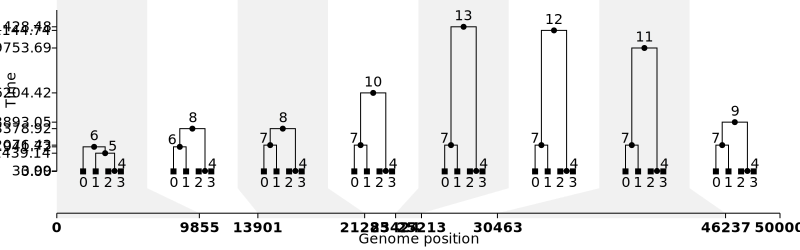

In [5]:
ts_tiny.draw_svg(size=svg_size, y_axis=True)

One way to avoid overlapping labels on the Y axis is to use the `y_ticks` parameter,
which will be used in most subsequent examples in this tutorial.

### Larger tree sequences

So far, we have plotted only very small tree sequences. To visualize larger tree
sequences it is sometimes advisable to focus on a small region of the genome, possibly
even a single tree. The `x_lim` parameter allows you to plot the part of a tree
sequence that spans a particular genomic region: here's a slighly larger tree sequence
with 8 samples, but where we've restricted the amount of the tree sequence we plot:

The tree sequence between positions 5000 and 15000 ...


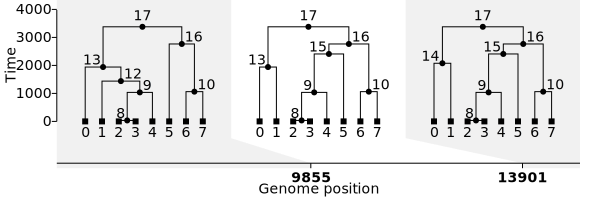

... or just look at (say) the third tree


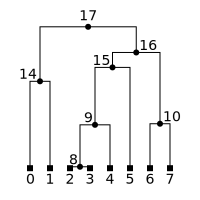

In [6]:
x_limits = [5000, 15000]
# Create evenly-spaced y tick positions to avoid overlap
y_tick_pos = [0, 1000, 2000, 3000, 4000]

print("The tree sequence between positions {} and {} ...".format(*x_limits))
display(ts_small.draw_svg(y_axis=True, y_ticks=y_tick_pos, x_lim=x_limits))

third_tree = ts_small.at_index(2)
print("... or just look at (say) the third tree")
display(third_tree.draw_svg())

As the number of sample nodes increases, internal nodes often bunch up at recent time
points, obscuring relationships. Setting `time_scale="rank"`, as in the first SVG plot,
is one way to solve this. Another is to use a log-scale on the time axis, which can be
done by specifying `time_scale="log_time"`, as below. To compare node times across the
plot, this example also uses the `y_gridlines` option, which puts a very faint grid
line at each y tick (if you are finding the lines difficult to see, note that the line
intensity, along with many other plot features, can be modified through
{ref}`styling <sec_tskit_viz_styling>`, which we also use in this example to avoid
overlapping text by shrinking the node labels and rotating those associated with leaves;
styling is detailed {ref}`later in this tutorial <sec_tskit_viz_styling>`).

(sec_tskit_viz_large_tree_sequence)=

A larger tree, on a log timescale


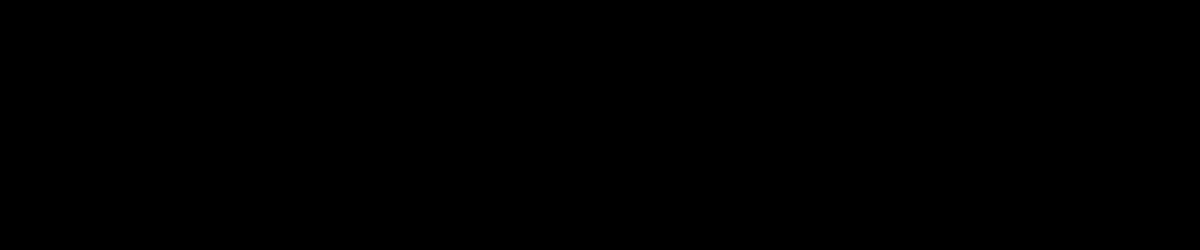

In [7]:
print("A larger tree, on a log timescale")
wide_fmt = (1200, 250)
# Create a stylesheet that shrinks labels and rotates leaf labels, to avoid overlap
node_label_style = (
    ".node > .lab {font-size: 80%}"
    ".leaf > .lab {text-anchor: start; transform: rotate(90deg) translate(6px)}"
)
ts_full.first().draw_svg(
    size=wide_fmt,
    time_scale="log_time",
    y_gridlines=True,
    y_axis=True,
    y_ticks=[1, 10, 100, 1000],
    style=node_label_style,
)

### Plotting mutations

The SVG visualization also allows mutations to displayed on the tree or tree sequence.
Here are the same plots as above but where the tree sequence now contains mutations. Each
mutation is plotted as a red cross on the branch where it occurs. This mutation symbol is
placed either at the mutation's known time, or spaced evenly along the branch (if the
mutation time is unknown or the `time_scale` parameter has been set to `"rank"`).
By default, each mutation is also labelled with its {class}`mutation ID<tskit.Mutation>`.

If the X axis is shown (which it is by default when drawing a tree sequence, but not
when drawing an individual tree) then the sites are plotted using a black tickmark above
the axis line. Each plotted mutation at the site is then overlaid on top of this
as a red downwards-pointing chevron.

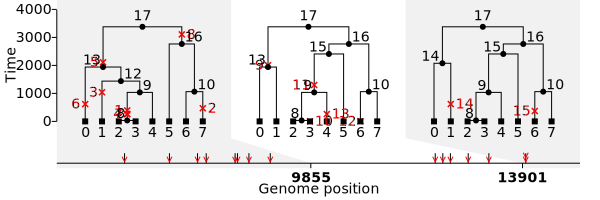

In [8]:
ts_mutated = msprime.sim_mutations(ts_small, rate=1e-7, random_seed=342)
ts_mutated.draw_svg(y_axis=True, y_ticks=y_tick_pos, x_lim=x_limits)

Note that, unusually, the rightmost site on the axis has more than one stacked chevron,
indicating that multiple mutations in the tree occur at the same site. These could be
mutations to different allelic states, or recurrent/back mutations. In this case the
mutations, 14 and 15 (above nodes 1 and 6) are recurrent mutations from T to G.

In [9]:
ts_mutated = tskit.load("data/viz_ts_small_mutated.trees")
site_descr = str(next(ts_mutated.at_index(2).sites()))
print(site_descr.replace("[", "[\n  ").replace("),", "),\n ").replace("],", "],\n"))

Site(id=14, position=13963.0, ancestral_state='T', mutations=[
  Mutation(id=14, site=14, node=1, derived_state='G', parent=-1, metadata=b'', time=619.6499091610359, edge=14),
  Mutation(id=15, site=14, node=6, derived_state='G', parent=-1, metadata=b'', time=370.24979591084764, edge=4)],
 metadata=b'')


#### Which mutations are shown?

When using the `x_lim` parameter, only the mutations in the plotted region are shown.
For the third tree in the tree sequence visualization above, we thus haven't plotted
mutations above position 15000. We can see *all* the mutations in the tree by changing the
plot region, or simply plotting the tree itself:

The third tree in the mutated tree sequence, which covers Interval(left=13901.0, right=21285.0)


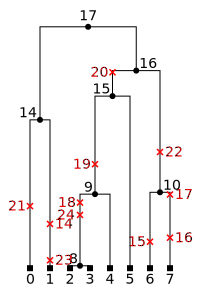

In [10]:
third_tree = ts_mutated.at_index(2)
print(f"The third tree in the mutated tree sequence, which covers {third_tree.interval}")
third_tree.draw_svg(size=(200, 300))

(sec_tskit_viz_extra_mutations)=

However, when plotting a single tree it may not be evident that identical branches
may exist in several adjacent trees, indicating an {ref}`edge <tskit:sec_introduction>`
that persists across adjacent trees. For instance the rightmost branch in the tree above,
from node 10 down to 7, exists in the previous two trees too. Indeed, this edge has a
mutation on it at position 6295, in the first tree. This mutation is not plotted in the
tree above, but if you want *all* the mutations on each edge to be plotted, you can set
the `all_edge_mutations` parameter to `True`. This adds any extra mutations that are
associated with an edge in the tree but which fall outside the interval of that tree; by
default these mutations are drawn in a slightly different shade (e.g. mutation 64 below).

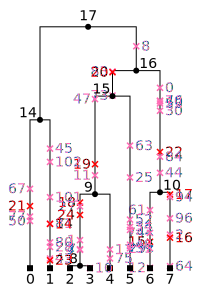

In [11]:
third_tree.draw_svg(size=(200, 300), all_edge_mutations=True)

### Labelling

Although the default node and mutation labels show unique identifiers, they are't
terribly intuituive. The `node_labels` and `mutation_labels` parameters can be used
to set more meaningful labels (for example from the tree sequence {ref}`sec_metadata`).

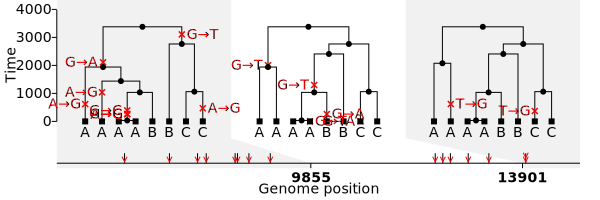

In [12]:
nd_labels = {}  # An array of labels for the nodes
for n in ts_mutated.nodes():
    # Set sample node labels from metadata. Here we use the population name, but you might want
    # to use the *individual* name instead, if the individuals in your tree sequence have names
    if n.is_sample():
        nd_labels[n.id] = ts_mutated.population(n.population).metadata["name"]

mut_labels = {}  # An array of labels for the mutations
for mut in ts_mutated.mutations():  # Make pretty labels showing the change in state
    site = ts_mutated.site(mut.site)
    older_mut = mut.parent >= 0  # is there an older mutation at the same position?
    prev = ts_mutated.mutation(mut.parent).derived_state if older_mut else site.ancestral_state
    mut_labels[mut.id] = f"{prev}→{mut.derived_state}"

ts_mutated.draw_svg(
    y_axis=True, y_ticks=y_tick_pos, x_lim=x_limits,
    node_labels=nd_labels,
    mutation_labels=mut_labels,
)

(sec_tskit_viz_styling)=

### Styling

The SVG output produced by tskit contains a large number of
[classes](https://www.w3.org/TR/SVG2/styling.html#ClassAttribute) which can be used to
target different elements of the drawing, allowing them to be hidden, styled, or
otherwise manipulated. This is done by passing a
[cascading style sheet (CSS)](https://www.w3.org/TR/SVG/styling.html) string to
`draw_svg`. A common use of styles is to colour nodes by their population:

".node.p0 > .sym {fill: red}" applies to nodes from population A (id 0)
".node.p1 > .sym {fill: green}" applies to nodes from population B (id 1)
".node.p2 > .sym {fill: blue}" applies to nodes from population C (id 2)
CSS string applied:
    ".node.p0 > .sym {fill: red} .node.p1 > .sym {fill: green} .node.p2 > .sym {fill: blue}"


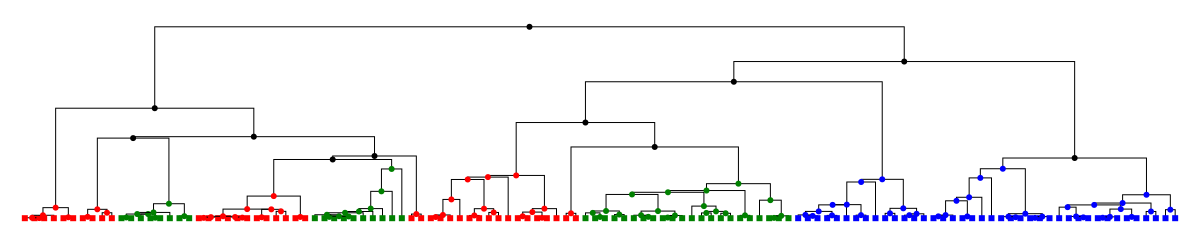

In [13]:
styles = []
# Create a style for each population, programmatically (or just type the string by hand)
for colour, p in zip(['red', 'green', 'blue'], ts_full.populations()):
    # target the symbols only (class "sym")
    s = f".node.p{p.id} > .sym " + "{" + f"fill: {colour}" + "}"
    styles.append(s)
    print(f'"{s}" applies to nodes from population {p.metadata["name"]} (id {p.id})')
css_string = " ".join(styles)
print(f'CSS string applied:\n    "{css_string}"')

ts_full.first().draw_svg(
    size=wide_fmt,
    node_labels={},    # Remove all node labels for a clearer viz
    style=css_string,  # Apply the stylesheet
)

Colouring nodes by population makes it immediately clear that, while the tree structure
does not exactly reflect the population divisions, there's still considerable
population substructure present in this larger tree.

:::{todo}
The (older) {meth}`Tree.draw` function also has a `node_colour` argument that can be
used to colour tree nodes, which is used in some of the other tskit tutorials. Under the
hood, this function simply sets appropriate SVG styles on nodes. We intend to make it
easier to set colours in a similar way: see https://github.com/tskit-dev/tskit/issues/579.
:::


The CSS string used to style the tree above takes advantage of the general classes defined
in a tskit SVG file: a node symbol always has a class named `sym`, which is contained
within a [grouping element](https://www.w3.org/TR/SVG2/struct.html#Groups) of class
`node`. Moreover, elements such as `node` have *additional* classes, such as `p1`,
indicating that the node in this case belongs to the population with ID 1.

#### Available css classes

Here are the css classes in a tskit SVG which can be used to style specific elements.

##### Within the plotting area

* `tree`: a grouping element containing each tree
* `node`: a grouping element within a tree, containing a node and its descendant
    elements such as a node symbol, an edge, mutations, and other nodes.
* `mut`: a grouping element containing a mutation symbol and label
* `extra`: an extra class for mutations {ref}`outside the tree <sec_tskit_viz_extra_mutations>`
* `lab`: a label element (for a node, mutation, axis, tick number, etc.)
* `sym`: a symbol element (e.g. a node, mutation, or site symbol)
* `edge`: an edge element (i.e. a branch in a tree)
* `root`, `leaf` and `sample`: additional classes applied to a node group if the
    node is a root node, a leaf node or a sample node
* `unknown_time`: a class added to `mut` groups if the time of the mutation is
    {data}`tskit.UNKNOWN_TIME`.
* `rgt` and `lft`: additional classes applied to labels for left- or
    right-justification

##### Outside the plotting area

* `axes`: a grouping element containing the X and Y axes, if either are present
* `x-axis`, `y-axis`: more specific grouping elements contained within `axes`
* `tick`: a single tick on an axis, containing a tickmark line and a label
* `site`: a grouping element representing a site (plotted on the X axis), containing a
    site symbol (a tick line) and zero or more `mut` groups, each containing a
    chevron-shaped mutation symbol
* `background`: the shaded background of a tree sequence plot
* `grid`: a gridline

##### ID-based classes

Elements have additional classes based on the IDs of trees, nodes, parent (ancestor)
nodes, individuals, populations, mutations, and sites. These class names start with a
single letter (respectively `t`, `n`, `a`, `i`, `p`, `m`, and `s`) followed by a
numerical ID. For example, here's a typical node in an tskit SVG plot:

```
<g class="a10 i3 leaf m16 m17 node n7 p2 s15 s16 sample">...</g>
```

This corresponds to node 7, the rightmost leaf in the third tree in the mutated tree
sequence (plotted in the previous section but one). The classes indicate that it
has an immediate ancestor (parent) node with ID 10 (`a10`), and that the node
belongs to an {ref}`individual <sec_nodes_or_individuals>` with ID 3 (`i3`).
The classes `n7` and `p2` tell us that the node ID is 7 and is is from the
population with ID 2 (`p2`). Other ID classes on the node tell us about the mutations
above that node, of which there are two in this case, with
IDs 16 and 17 (`m16`, `m17`); those mutations are associated with
site IDs 15 and 16 (`s16`, `s17`).

Other grouping elements apart from nodes can also contain ID-based classes. For example
the `tree` group contains the ID of the tree (e.g. `t0`), the `site` group on the X axis
contains the site ID (e.g. `s15`) the `mut` class contains the mutation ID (e.g. `m16`),
and so on.

#### Styling graphical elements 

The classes above make it easy to target specific nodes or edges in one or multiple
trees. For example, we can colour branches that are shared between trees
(identified here as ones that have the same parent and child):

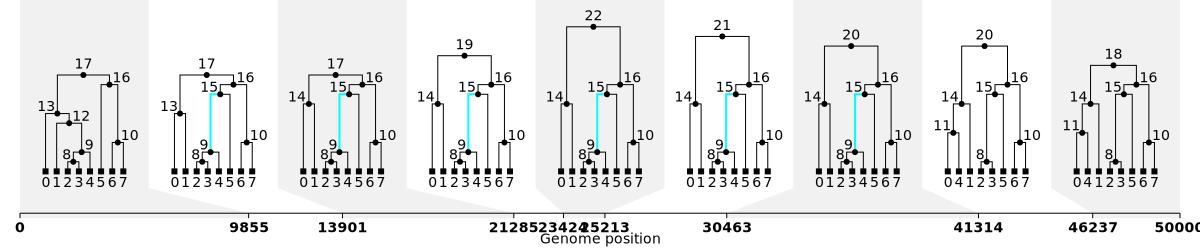

In [14]:
css_string = ".a15.n9 > .edge {stroke: cyan; stroke-width: 2px}"  # branches from 15->9
ts_small.draw_svg(time_scale="rank", size=wide_fmt, style=css_string)

By generating the css string programatically, you can target all the edges present in a
particular tree, and see how they gradually disappear from adjacent trees. Here, for
example the branches in the central tree have been coloured red, as have the identical
branches in adjacent trees. The central tree represents a location in the genome
that has seen a selective sweep, and therefore has short branch lengths: adjacent trees
are not under direct selection and thus the black branches tend to be longer.
These (red) shared branches extending far on either side represent shared haplotypes,
and this shows how long, shared haplotypes can extend much further away from a sweep
than the region of reduced diversity (which is the region spanned by the short tree in the middle).
For visual clarity, node symbols and labels have been turned off.

In [15]:
# See the notebook code if you want to know how these tree sequences were produced
ts_selection = tskit.load("data/viz_ts_selection.trees")

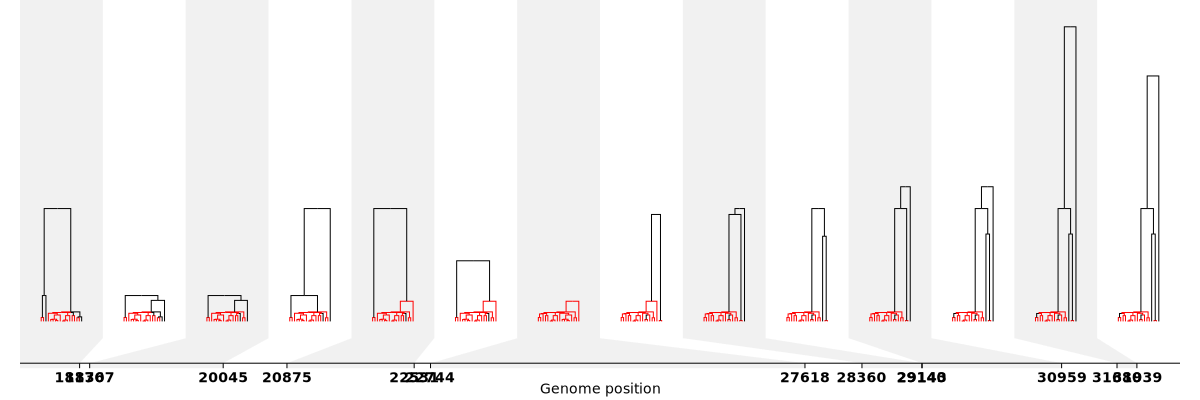

In [16]:
css_edge_targets = []  # collect the css targets of all the edges in the selected tree
sweep_location = ts_selection.sequence_length / 2  # NB: sweep is in the middle of the ts
focal_tree = ts_selection.at(sweep_location)
for node_id in focal_tree.nodes():
    parent_id = focal_tree.parent(node_id)
    if parent_id != tskit.NULL:
        css_edge_targets.append(f".a{parent_id}.n{node_id}>.edge")
css_string = ",".join(css_edge_targets) + "{stroke: red} .sym {display: none}"

wide_tall_fmt = (1200, 400)
ts_selection.draw_svg(
    style=css_string,
    size=wide_tall_fmt,
    x_lim=[1.74e4, 3.25e4],
    node_labels={},
)

:::{note}
Branches in multiple trees that have the same parent and child do not always
correspond to a single {ref}`edge <tskit:sec_introduction>`
in a tree sequence: for example, edges have the
additional constraint that they must belong to _adjacent_ trees.
:::

#### Moving graphical elements

We can also use styles to transform elements of the drawing, shifting them into different
locations or changing their orientation. For example,
{ref}`earlier in this tutorial <sec_tskit_viz_large_tree_sequence>` we used the
following CSS string to rotate leaf labels:

```css
.leaf > .lab {text-anchor: start; transform: rotate(90deg) translate(6px)}
```

Transformations not only allow us to shift e.g. labels about, but also change the size
of symbols, which can create rather different formatting styles:

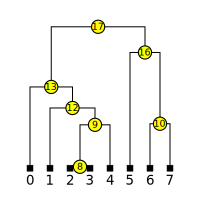

In [17]:
css_string = (
    # Draw large yellow circles for nodes ...
    ".node > .sym {transform: scale(2.2); fill: yellow; stroke: black; stroke-width: 0.5px}"

    # ...but for leaf nodes, override the yellow circle using a more specific CSS target
    ".node.leaf > .sym {transform: scale(1); fill:black}"

    # Override default node text position to be based at (0, 0) relative to the node pos
    # Note that the .tree specifier is needed to make this more specific than the default
    # positioning which is targetted at ".lab.lft" and ".lab.rgt"
    ".tree .node > .lab {transform: translate(0, 0); text-anchor: middle; font-size: 7pt}"

    # For leaf nodes, override the above positioning using a subsequent CSS style
    ".node.leaf > .lab {transform: translate(0, 12px); font-size: 10pt}"
)
ts_small.first().draw_svg(style=css_string)

:::{note}
Using `transform` in styles is an SVG2 feature, and has not yet been implemented in
the software programs Inkscape or librsvg. Therefore if you are
{ref}`converting or editing <sec_tskit_viz_converting>` the examples above, symbol sizes
and label positions may be incorrect. The `symbol_size` option can be used if you want
to simply change the size of all symbols in the plot, but otherwise you may need
to use the `chromium` workaround documented {ref}`here <sec_tskit_viz_converting_note>`.
:::



#### Styling and SVG structure

To take full advantage of the SVG styling capabilities in tskit, it is worth knowing how
the SVG file is structured. In particular tskit SVGs use a hierarchical grouping
structure that reflects the tree topology. This allows easy styling and manipulation of
both individual elements and entire subtrees. Currently, the hierarchical structure of a
simple 2-tip SVG tree produced by tskit looks something like this:

```
<g class="tree t0">
  <g class="plotbox">
    <g class="node n2 root">
      <g class="node n1 a2 i1 p1 m0 s0 sample leaf">
        <path class="edge" ... />
        <g class="mut m0 s0" ...>
          <line .../>
          <path class="sym" .../>
          <text class="lab">Mutation 0</text>
        </g>
        <rect class="sym" ... />
        <text class="lab" ...>Node 1</text>
      </g>
      <g class="node n0 a2 i2 p1 sample leaf">
        <path class="edge" ... />
        <rect class="sym" .../>
        <text class="lab" ...>Node 0</text>
      </g>
      <path class="edge" ... />
      <circle class="sym" ... />
      <text class="lab">Root (Node 2)</text>
    </g>
  </g>
</g>
```

And in a tree sequence plot, the SVG simply consists of a set of such trees, together
with groups containing the background and axes, if required.
```
<g class="tree-sequence">
  <g class="background"></g>
  <g class="axes"></g>
  <g class="trees">
    <g class="tree t0">...</g>
    <g class="tree t1">...</g>
    <g class="tree t2">...</g>
    ...
    </g>
  </g>
</g>
    
```

#### Styling subtrees

The nested grouping structure makes it easy to target a node and all its descendants.
For instance, here's how to draw all the edges of node 13 and its descendants using a
thicker blue line:

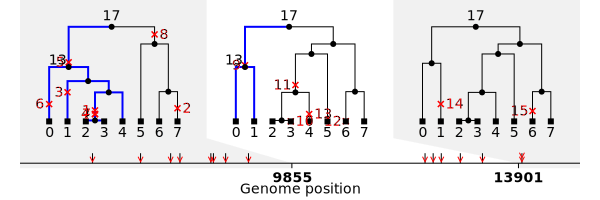

In [18]:
edge_style = ".n13 .edge {stroke: blue; stroke-width: 2px}"
nd_labs = {n: n for n in [0, 1, 2, 3, 4, 5, 6, 7, 13, 17]}
ts_mutated.draw_svg(x_lim=x_limits, node_labels=nd_labs, style=edge_style)

This might not be quite what you expected: the branch leading from node 13 to its parent 
(node 17) has also been coloured. That's because the SVG node group deliberately contains
the branch that leads to the parent (this can be helpful, for example, for hiding the
entire subtree leading to node 13, using e.g. `.n13 {display: none}`). To colour
the branches *descending* from node 13, you therefore need to target the nodes nested
at least one level deep within the `n13` group. One way to do that is to add an
extra `.node` class to the style, e.g.

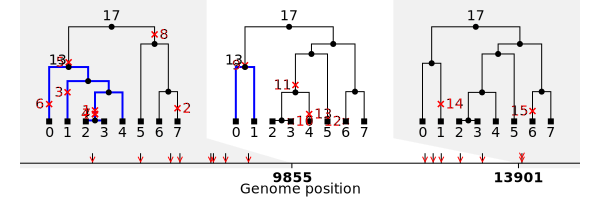

In [19]:
edge_style = ".n13 .node .edge {stroke: blue; stroke-width: 2px}"
# NB to target the edges in only (say) the 1st tree you could use ".t0 .n13 .node .edge ..."
ts_mutated.draw_svg(x_lim=x_limits, node_labels=nd_labs, style=edge_style)

If you want to colour the branches descending from a particular mutation (say mutation 7)
then you need to colour not only the edges, but also *part* of an edge (i.e. the line
that connects a mutation downwards to its associated node). The tskit SVG format provides
a special `<line>` element to enable this, which is normally made invisible using
`fill: none stroke: none` in the default stylesheet. Here's an example of activating
this normally-hidden line:

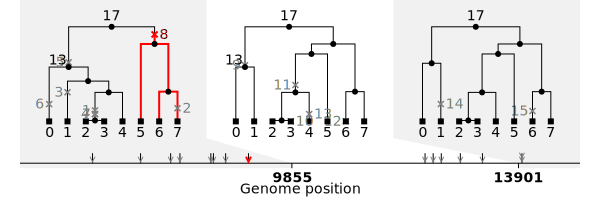

In [20]:
default_muts = ".mut .lab {fill: gray} .mut .sym {stroke: gray}"  # all other muts in gray
m8_mut = (
    ".m8 .node .edge, "  # the descendant edges
    ".mut.m8 line, "  # activate the hidden line between the mutation and the node
    ".mut.m8 .sym "  # the mutation symbols on the tree and the axis
    "{stroke: red; stroke-width: 2px}"
    ".mut.m8 .lab {fill: red}"  # colour the label "8" in red too
)
css_string = default_muts + m8_mut
ts_mutated.draw_svg(x_lim=x_limits, node_labels=nd_labs, style=css_string)

#### Restricting styling

Sometimes the hierarchical nesting leads to styles being applied too widely. For example,
since style selectors include all the descendants of a target, to target just the node
itself (and not its descendants) a slightly different specification is required,
involving, the "`>`" symbol, or
[child combinator](https://www.w3.org/TR/selectors-3/#child-combinators) (we have,
in fact, used it in several previous examples). The following plot shows the difference
when all decendant symbols are targetted, versus just the immediate child symbol:

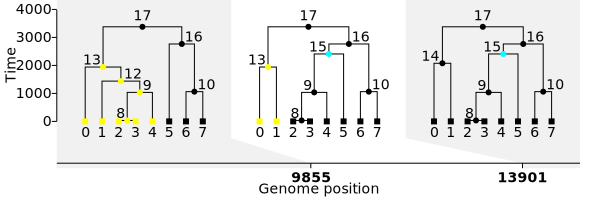

In [21]:
node_style1 = ".n13 .sym {fill: yellow}"  # All symbols under node 13 
node_style2 = ".n15 > .sym {fill: cyan}"  # Only symbols that are an immediate child of node 15
css_string = node_style1 + node_style2
ts_small.draw_svg(y_axis=True, y_ticks=y_tick_pos, x_lim=x_limits, style=css_string)

Another example of modifying the style target is *negation*. This is needed, for example,
to target nodes that are *not* leaves (i.e. internal nodes). One way to do this is to
target *all* the node symbols first, then replace the style with a more specific
targetting of the leaf symbols only:

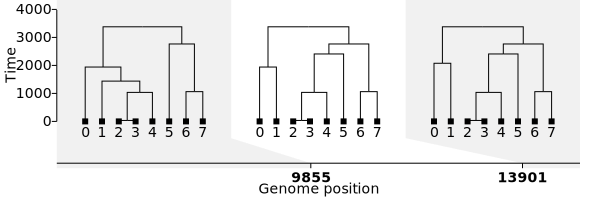

In [22]:
hide_internal_symlabs = ".node > .sym, .node > .lab {display: none}"
show_leaf_symlabs = ".node.leaf > .sym, .node.leaf > .lab {display: initial}"
css_string = hide_internal_symlabs + show_leaf_symlabs
ts_small.draw_svg(y_axis=True, y_ticks=y_tick_pos, x_lim=x_limits, style=css_string)

Alternatively, the `:not` selector can be used to target nodes that are *not* leaves,
so the following style specification should produce the same effect in SVG viewers that
support it (note, however, as of v1.2 Inkscape does not appear to support this selector).

```
style_string = ".node:not(.leaf) > .sym, .node:not(.leaf) > .lab {display: none}"
```

#### More about styling

NOTE: if your SVG is embedded directly into an HTML page (a common way for jupyter
notebooks to render SVGs), then according to the HTML specifications, any styles applied
to one SVG will apply to all SVGs in the document. To avoid this confusing state of
affairs,  we recommend that you tag the SVG with a unique ID using the
`root_svg_attributes` parameter, then prepend this ID to the style string:

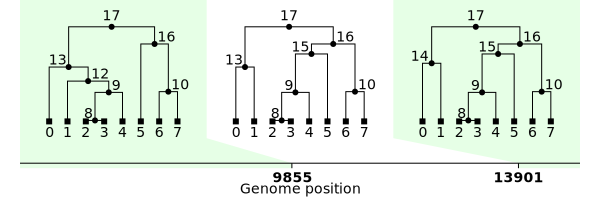

In [23]:
ts_small.draw_svg(
    x_lim=x_limits,
    root_svg_attributes={'id': "myUID"},
    style="#myUID .background * {fill: #00FF00}",  # apply any old style to this specific SVG
)

SVG styles allow a huge amount of flexibility in formatting your plot, even extending to
animations. Feel free to browse the {ref}`examples <sec_tskit_viz_SVG_examples>` for
inspiration.


(sec_tskit_viz_converting)=

### Converting and editing SVG

#### Converting

[Inkscape](https://inkscape.org) is an open source SVG editor that can also be scripted
to output bitmap files. 

[Imagemagick](https://imagemagick.org/) is a common piece of software used to convert
between image formats. It can
be configured to delegate to one of several different SVG libraries when converting
SVGs to bitmap formats. Currently, both the librsvg library or the Inkscape library
produce reasonable output, although librsvg currently misaligns some labels due to
[ignoring certain SVG properties](https://gitlab.gnome.org/GNOME/librsvg/-/issues/414).

(sec_tskit_viz_converting_note)=

:::{note}
A few stylesheet specifications, such as the `transform` property, are SVG2
features, and have not yet been implemented in Inkscape or librsvg.
Therefore if you use these in your own custom SVG stylesheet (such as the example
above where we rotated leaf labels), they will not be applied properly
when converted with those tools. For custom stylesheets like this, a workaround is
to convert the SVG to PDF first, using e.g. the programmable chromium engine: 
```
chromium --headless --print-to-pdf=out.pdf in.svg
```
The resulting PDF file can then be converted by Inkscape, retaining the correct
transformations.
:::

#### Editing the SVG

- Editing can be done in [Inkscape](https://inkscape.org) (subject to the note above)

:::{todo}
Tips on how to cope with the hierarchical grouping when editing (e.g. in Inkscape using
`Extensions menu > Arrange > Deep Ungroup`, but note that this will mess with the styles!)
:::


(sec_tskit_viz_examples)=
## Examples

### Text examples

#### Tree orientation
In the text format, trees (but not tree sequences) can be displayed in different orientations

In [24]:
from IPython.display import HTML
orient = "top", "left", "bottom", "right"
html = []
for o in orient:
    tree_string = ts_small.first().draw_text(orientation=o)
    html.append(f"<pre style='display: inline-block'>{tree_string}</pre>")
HTML(("&nbsp;"*10).join(html))

(sec_tskit_viz_SVG_examples)=
### SVG examples

#### A standard ts plot
Note that this tree sequence also illustrates a few features which are not normally
produced e.g. by `msprime` simulations, in particular a "empty" site (with no
associated mutations) at position 50, and some mutations that occur above root nodes in
the trees. Graphically, root mutations necessitate a line above the root node on which to
place them, so each tree in this SVG has a nominal "root branch" at the top. Normally,
root branches are not drawn, unless the `force_root_branch` parameter is specified.

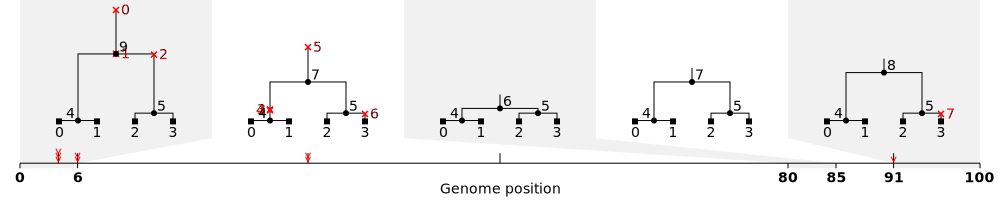

In [25]:
ts = tskit.load("data/viz_root_mut.trees")
ts.draw_svg()

#### A fancy formatted plot

Here we have activated the Y axis, and changed the node style. In particular, we have
coloured nodes by time, and increased the internal node symbol size while moving
the internal node labels into the symbol; node labels have also been plotted in a
sans-serif font. Axis tick labels have been changed to avoid potential overlapping (some
Y tick labels have been removed, and the X tick labels rotated).

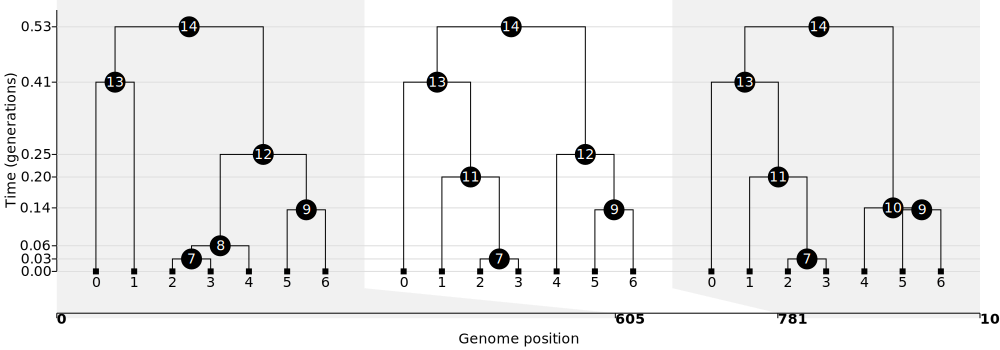

In [26]:
import numpy as np
seed=370009
ts = msprime.sim_ancestry(7, ploidy=1, sequence_length=1000, random_seed=seed, recombination_rate=0.001)
y_ticks = ts.tables.nodes.time
# Thin the tick values so we don't get labels within 0.01 of each other
y_ticks = np.delete(y_ticks, np.argwhere(np.ediff1d(y_ticks) <= 0.01))

css_string = (
    ".tree .lab {font-family: sans-serif}"
    # Normal X axis tick labels have dominant baseline: hanging, but it needs centring when rotated
    + ".x-axis .tick .lab {text-anchor: start; dominant-baseline: central; transform: rotate(90deg)}"
    + ".y-axis .grid {stroke: #DDDDDD}"
    + ".tree :not(.leaf).node > .lab  {transform: translate(0,0); text-anchor:middle; fill: white}"
    + ".tree :not(.leaf).node > .sym {transform: scale(3.5)}"
    + "".join(f".tree .n{n.id} > .sym {{fill: hsl({int((1-n.time/ts.max_root_time)*260)}, 50%, 50%)}}" for n in ts.nodes())
)
ts.draw_svg(size=(1000, 350), y_axis=True, y_gridlines=True, y_ticks=y_ticks, style=css_string)

#### Highlighted mutations

Specific mutations can be given a different colour. Moreover, the descendant lineages of
specific mutations can be coloured and the branch colours overlay each other as expected.
Note that in this example, internal node labels and symbols have been hidden for clarity.

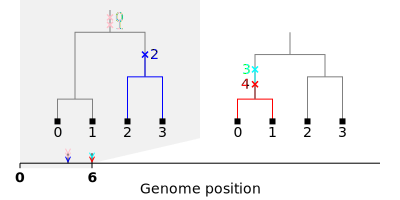

In [27]:
ts = tskit.load("data/viz_root_mut.trees")
css_string = (
    ".edge {stroke: grey}"
    ".mut .sym{stroke:pink} .mut text{fill:pink}"
    ".mut.m2 .sym, .m2>line, .m2>.node .edge{stroke:blue} .mut.m2 .lab{fill:blue}"
    ".mut.m3 .sym, .m3>line, .m3>.node .edge{stroke:cyan} .mut.m3 .lab{fill:cyan}"
    ".mut.m4 .sym, .m4>line, .m4>.node .edge{stroke:red} .mut.m4 .lab{fill:red}"
    # Hide internal node labels & symbols
    ".node:not(.leaf) > .sym, .node:not(.leaf) > .lab {display: none}"
)
ts.draw_svg(style=css_string, time_scale="rank", x_lim=[0, 30])

#### Leaf, sample & isolated nodes
By default, sample nodes are square and non-sample nodes circular (at the moment this
can't easily be changed). However, neither need to be at specific times: sample nodes can
be at times other than 0, and nonsample nodes can be at time 0. Moreover, leaves need not
be samples, and samples need not be leaves. Here we change the previous tree sequence to
make some leaves non-samples and some samples internal nodes. To highlight the change,
we have plotted sample nodes in green, and leaf nodes (if not samples) in blue.

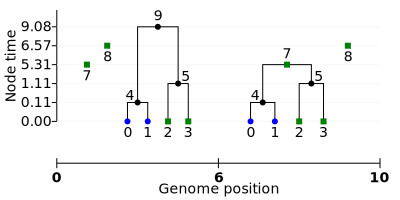

In [28]:
tables = tskit.load("data/viz_root_mut.trees").dump_tables()
tables.mutations.clear()
tables.sites.clear()
tables.nodes.flags = np.array([0, 0, 1, 1, 0, 0, 0, 1, 1, 0], dtype=tables.nodes.flags.dtype)
ts = tables.tree_sequence()
css_string=".leaf .sym {fill: blue} .sample > .sym {fill: green}"
ts.draw_svg(style=css_string, x_scale="treewise", time_scale="rank", y_axis=True, y_gridlines=True, x_lim=[0, 10])

:::{note}
By definition, if a node is a sample, it must be present in every tree. This
means that there can be sample nodes which are "isolated" in a tree. These are drawn
unconnected to the main topology in one or more trees (e.g. nodes 7 and 8 above).
:::

#### Tick labels and gridlines

Y tick labels can be specified explicitly, which allows time scales to be plotted
e.g. in years even if the tree sequence ticks in generations. The grid lines associated
with each y tick can also be changed or even hidden individually using the CSS
[nth-child pseudo-selector](https://www.w3.org/TR/2018/REC-selectors-3-20181106/#nth-child-pseudo),
where tickmarks are indexed from the bottom. This is used in
the {ref}`sec_msprime_introgression` tutorial to show lines behind the trees at specific,
important times. Below we show a slightly simpler example than in that tutorial,
keeping node and mutation symbols in black, but colouring gridlines instead:

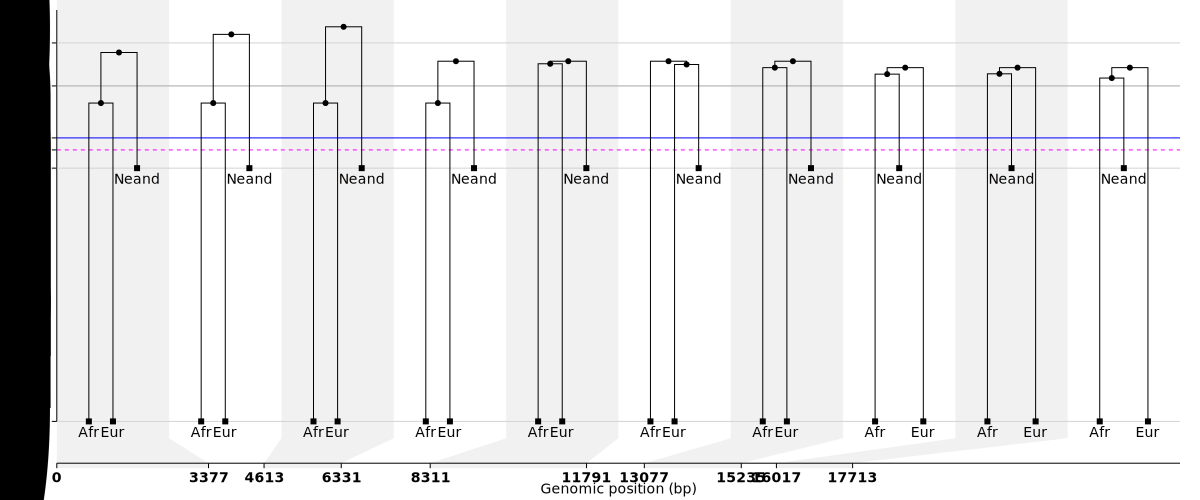

In [29]:
# Function from the introgression tutorial - see there for justification
import msprime
time_units = 1000 / 25  # Conversion factor for kya to generations

def run_simulation(sequence_length, random_seed=None):
    demography = msprime.Demography()
    # The same size for all populations; highly unrealistic!
    Ne = 10**4
    demography.add_population(name="Africa", initial_size=Ne)
    demography.add_population(name="Eurasia", initial_size=Ne)
    demography.add_population(name="Neanderthal", initial_size=Ne)

    # 2% introgression 50 kya
    demography.add_mass_migration(
        time=50 * time_units, source='Eurasia', dest='Neanderthal', proportion=0.02)
    # Eurasian 'merges' backwards in time into Africa population, 70 kya
    demography.add_mass_migration(
        time=70 * time_units, source='Eurasia', dest='Africa', proportion=1)
    # Neanderthal 'merges' backwards in time into African population, 300 kya
    demography.add_mass_migration(
        time=300 * time_units, source='Neanderthal', dest='Africa', proportion=1)

    ts = msprime.sim_ancestry(
        recombination_rate=1e-8,
        sequence_length=sequence_length,  
        samples=[
            msprime.SampleSet(1, ploidy=1, population='Africa'),
            msprime.SampleSet(1, ploidy=1, population='Eurasia'),
            # Neanderthal sample taken 30 kya
            msprime.SampleSet(1, ploidy=1, time=30 * time_units, population='Neanderthal'),
        ],
        demography = demography,
        record_migrations=True,  # Needed for tracking segments.
        random_seed=random_seed,
    )
    return ts

ts = run_simulation(20 * 10**6, 1)

css = ".y-axis .tick .lab {font-size: 85%}"  # Multi-line labels unimplemented: use smaller font 
css += ".y-axis .tick .grid {stroke: lightgrey}"  # Default gridline type
css += ".y-axis .ticks .tick:nth-child(3) .grid {stroke-dasharray: 4}"  # 3rd line from bottom
css += ".y-axis .ticks .tick:nth-child(3) .grid {stroke: magenta}"  # also 3rd line from bottom
css += ".y-axis .ticks .tick:nth-child(4) .grid {stroke: blue}"  # 4th line from bottom
css += ".y-axis .ticks .tick:nth-child(5) .grid {stroke: darkgrey}"  # 5th line from bottom
y_ticks = {0: "0", 30: "30", 50: "Introgress", 70: "Eur origin", 300: "Nea origin", 1000: "1000"}
y_ticks = {y * time_units: lab for y, lab in y_ticks.items()}
ts.draw_svg(
    size=(1200, 500),
    x_lim=(0, 25_000),
    time_scale="log_time",
    node_labels = {0: "Afr", 1: "Eur", 2: "Neand"},
    y_axis=True,
    y_label="Time (kya)",
    x_label="Genomic position (bp)",
    y_ticks=y_ticks,
    y_gridlines=True,
    style=css,
)

#### Animation

The classes attached to the SVG also allow elements to be animated. Here's a
[d3.js](https://d3js.org)-based animation of sucessive subtree-prune-and-regraft (SPR)
operations, using the {ref}`ARG representation <msprime:sec_ancestry_full_arg>` of a
tree sequence to allow identification of pruned edges.

In [30]:
css_string = ".node:not(.sample) > .lab, .node:not(.sample) > .sym {display: none}"
html_string = r"""
<div id="animated_svg_canvas">%s</div>
<script type="text/javascript" src="https://d3js.org/d3.v4.min.js"></script>
<script type="text/javascript">
function diff(A) {return A.slice(1).map((n, i) => { return n - A[i]; });};
function mean(A) {return A.reduce((sum, a) => { return 0 + sum + a },0)/(A.length||1);};
function getRelativeXY(canvas, element, x, y) {
  var p = canvas._groups[0][0].createSVGPoint();
  var ctm = element.getCTM();
  p.x = x || 0;
  p.y = y || 0;
  return p.matrixTransform(ctm);
};

function animate_SPR(canvas, num_trees) {
  d3.selectAll(".tree").attr("opacity", 0);
  for(var i=0; i<num_trees - 1; i++) 
  {
    var source_tree = ".tree.t" + i;
    var target_tree = ".tree.t" + (i+1);
    var dur = 2000;
    var delay = i * dur;
    d3.select(source_tree)
      .datum(function() { return d3.select(this).attr("transform")}) // store the original value
      .transition()
      .on("start", function() {d3.select(this).attr("opacity", "1");}) 
      .delay(delay)
      .duration(dur)
      .attr(
        "transform", d3.select(target_tree).attr("transform"))
      .on("end", function() {
        d3.select(this).attr("opacity", "0");
        d3.select(this).attr("transform", d3.select(this).datum()); // reset
      });
    transform_tree(canvas, source_tree, target_tree, dur, delay);
  }
};

// NB - this is buggy and doesn't correctly reset the transformations on the elements
// because it is hard to put the subtree back into the correct place in the hierarchy

function transform_tree(canvas, src_tree, target_tree, dur, delay) {
  canvas.selectAll(src_tree + " .node").each(function() {
    var n_ids = d3.select(this).attr("class").split(/\s+/g).filter(x=>x.match(/^n\d/));
    if (n_ids.length != 1) {alert("Bad node classes in SVG tree")};
    var node_id = n_ids[0].replace(/^n/, "")
    var src = src_tree + " .node.n" + node_id;
    var target = target_tree + " .node.n" + node_id;

    if (d3.select(src).nodes()[0] && d3.select(target).nodes()[0]) {
      // The same source and target edges exist, so we can simply move them
      d3.select(src).transition()
        .delay(delay)
        .duration(dur)
        .attr("transform", d3.select(target).attr("transform"))
      var selection = d3.select(src + " > .edge");
      if (!selection.empty()) { // the root may not have an edge
        selection.transition()
          .delay(delay)
          .duration(dur)
          .attr("d", d3.select(target +" > .edge").attr("d"))
      }
    } else {
      // No matching node: this could be a recombination
      // Hack: the equivalent recombination node is the next one labelled
      var target = target_tree + " .node.n" + (1+parseInt(node_id));
      // Extract the edge
      src_tree_pos = getRelativeXY(canvas, d3.select(src_tree).node());
      target_tree_pos = getRelativeXY(canvas, d3.select(target_tree).node());
      src_xy = getRelativeXY(canvas, d3.select(src).node());
      target_xy = getRelativeXY(canvas, d3.select(target).node());
      // Move the subtree out of the hierarchy and into the local tree space,
      // so that movements of the containing hierarchy do not affect position
      d3.select(src_tree).append(
        () => d3.select(src)
          .attr(
            "transform",
            "translate(" + (src_xy.x - src_tree_pos.x) + " " + (src_xy.y - src_tree_pos.y) + ")"
          )
          .remove()
          .node()
      );
      d3.select(src).transition()
        .delay(delay)
        .duration(dur)
        .attr(
          "transform",
          "translate(" + (target_xy.x-target_tree_pos.x) + " " + (target_xy.y-target_tree_pos.y) + ")")
      selection = d3.select(src + " > .edge");
      if (!selection.empty()) {
        selection.transition()
          .delay(delay)
          .duration(dur)
          .attr("d", d3.select(target +" > .edge").attr("d"))
      }
    }
  })
};

var svg_text = document.getElementById("animated_svg_canvas").innerHTML;

</script>

<button onclick='animate_SPR(d3.select("#animated_svg_canvas svg"), %s);'>Animate</button>
<button onclick='document.getElementById("animated_svg_canvas").innerHTML = svg_text;'>Reset</button>
"""

ts = tskit.load("data/viz_spr_animation.trees")
# created with record_full_arg needed to track recombination nodes (branch positions)

HTML(html_string % (ts.draw_svg(style=css_string), ts.num_trees))

  

(sec_tskit_viz_other)=
## Other visualizations

As well as visualizing a tree sequence as, well, a sequence of local trees, or by plotting
{ref}`statistical summaries <tskit:sec_stats>`, other visualizations are possible, some
of which are outlined below.

(sec_tskit_viz_other_graph)=

### Graph representations

A tree sequence can be treated as a specific form of (directed)
[graph](https://en.wikipedia.org/wiki/Graph_(discrete_mathematics)) consisting
of nodes connected by edges. Standard graph visualization software, such as
[graphviz](https://graphviz.org) can therefore be used to represent tree sequence
topologies. This is a relatively common approach to visualizing the full
"Ancestral Recombination Graph" or ARG (a structure in which some nodes are
"recombination nodes", and which is possible to 
{ref}`represent as a tree sequence <msprime:sec_ancestry_full_arg>`).


:::{todo}
Link to the ARG tutorial,
[once it is created](https://github.com/tskit-dev/tutorials/issues/43), and show a
picture like this:

![A tree sequence (ARG) as a graph](https://user-images.githubusercontent.com/36134434/109398193-2ec6b700-7933-11eb-9cbf-99fdfab46df0.png)
(from [here](https://github.com/tskit-dev/tutorials/issues/43#issuecomment-787124425))
:::

(sec_tskit_viz_other_demographic)=

### Demographic processes

If you are generating a tree sequence via a {ref}`Demes <msprime:sec_demography_importing>`
model, then you can visualize a schematic of the demography itself (rather than the
resulting tree sequence) using the [DemesDraw](https://grahamgower.github.io/demesdraw/)
software. For example, here's the plotting code to generate the
{ref}`demography plot<sec_what_is_ancestry>` from the "{ref}`sec_what_is`" tutorial:

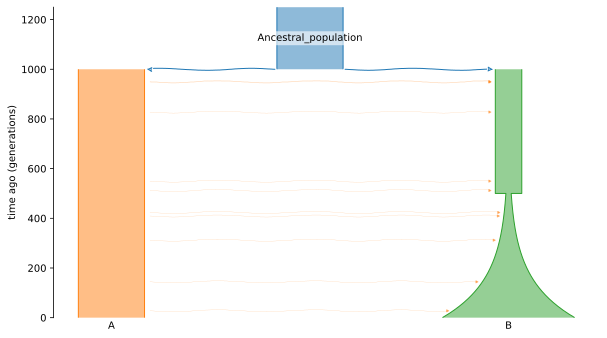

In [31]:
import matplotlib_inline
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

import demes
import demesdraw

def size_max(graph):
    return max(
        max(epoch.start_size, epoch.end_size)
        for deme in graph.demes
        for epoch in deme.epochs
    )

# See https://popsim-consortium.github.io/demes-docs/ for the yml spec for the file below
graph = demes.load("data/whatis_example.yml")
w = 1.5 * size_max(graph)
positions = dict(Ancestral_population=0, A=-w, B=w)
ax = demesdraw.tubes(graph, positions=positions, seed=1)
plt.show(ax.figure)

### Geography

:::{todo}
How to get lat/long information out of a tree sequence and plot ancestors (or a tree)
on a geographical landscape.
:::